### MLP Model v2

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import split_sequence, get_apple_close_price, plot_series
from utils import plot_residual_forecast_error, print_performance_metrics
from utils import get_range, difference, inverse_difference
from utils import train_test_split, NN_walk_forward_validation

In [2]:
apple_close_price = get_apple_close_price()

In [3]:
short_series = get_range(apple_close_price, '2003-01-01')

In [112]:
# Model parameters
look_back = 5 # days window look back
n_features = 1 # our only feature will be Close price 
n_outputs = 5 # days forecast
batch_size = 32 # for NN, batch size before updating weights
n_epochs = 1000 # for NN, number of training epochs

We need to first train/test split, then transform and scale our data

In [113]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [114]:
train, test= train_test_split(apple_close_price,'2018-05-31')

In [115]:
boxcox_series, lmbda = boxcox(train.values)

In [116]:
transformed_train = boxcox_series
transformed_test = boxcox(test, lmbda=lmbda)

# transformed_train = train.values
# transformed_test = test.values

In [117]:
from sklearn.preprocessing import MinMaxScaler

In [162]:
scaler = MinMaxScaler()

In [163]:
scaled_train = scaler.fit_transform(transformed_train.reshape(-1, 1))
scaled_test = scaler.transform(transformed_test.reshape(-1, 1))

In [164]:
X_train, y_train = split_sequence(scaled_train, look_back, n_outputs)
y_train = y_train.reshape(-1, n_outputs)

In [165]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from keras.layers import LeakyReLU, BatchNormalization, Dropout
from keras.optimizers import Adam

import warnings
warnings.simplefilter('ignore')

In [166]:
def build_MLP(look_back, n_features, n_outputs, optimizer='adam'):
    model = Sequential()

    model.add(Dense(64, input_shape=(look_back, n_features)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(n_outputs))

    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

In [167]:
model = build_MLP(look_back, n_features, n_outputs, optimizer=Adam(0.0001))

In [168]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 5, 64)             128       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 5, 64)             0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 320)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 5)                 1605      
Total params: 1,733
Trainable params: 1,733
Non-trainable params: 0
_________________________________________________________________


In [169]:
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, shuffle=False)

Epoch 1/1000
9439/9439 [==============================] - 1s 140us/step - loss: 0.0525
Epoch 2/1000
9439/9439 [==============================] - 1s 82us/step - loss: 0.0022
Epoch 3/1000
9439/9439 [==============================] - 1s 82us/step - loss: 0.0016
Epoch 4/1000
9439/9439 [==============================] - 1s 82us/step - loss: 0.0011
Epoch 5/1000
9439/9439 [==============================] - 1s 82us/step - loss: 7.1838e-04
Epoch 6/1000
9439/9439 [==============================] - 1s 84us/step - loss: 4.3868e-04
Epoch 7/1000
9439/9439 [==============================] - 1s 82us/step - loss: 2.7228e-04
Epoch 8/1000
9439/9439 [==============================] - 1s 82us/step - loss: 1.9051e-04
Epoch 9/1000
9439/9439 [==============================] - 1s 82us/step - loss: 1.5508e-04
Epoch 10/1000
9439/9439 [==============================] - 1s 81us/step - loss: 1.4151e-04
Epoch 11/1000
9439/9439 [==============================] - 1s 82us/step - loss: 1.3676e-04
Epoch 12/1000
9439/9439

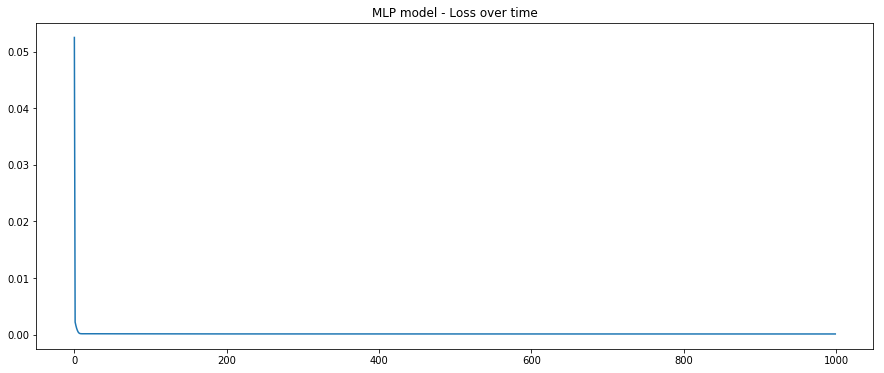

In [170]:
plot_series(history.history['loss'], title='MLP model - Loss over time')

In [171]:
model.save_weights('mlp-model_weights.h5')

In [172]:
size = 252 # approx. one year
predictions = NN_walk_forward_validation(model, 
                                         scaled_train, scaled_test[:252],
                                         size=size,
                                         look_back=look_back, 
                                         n_outputs=n_outputs)

In [173]:
from utils import plot_walk_forward_validation
from utils import plot_residual_forecast_error, print_performance_metrics

We need to revert the scaling and transformation:

In [174]:
descaled_preds = scaler.inverse_transform(predictions.reshape(-1, 1))
descaled_test = scaler.inverse_transform(scaled_test.reshape(-1, 1))

descaled_preds = inv_boxcox(descaled_preds, lmbda)
descaled_test = inv_boxcox(descaled_test, lmbda)

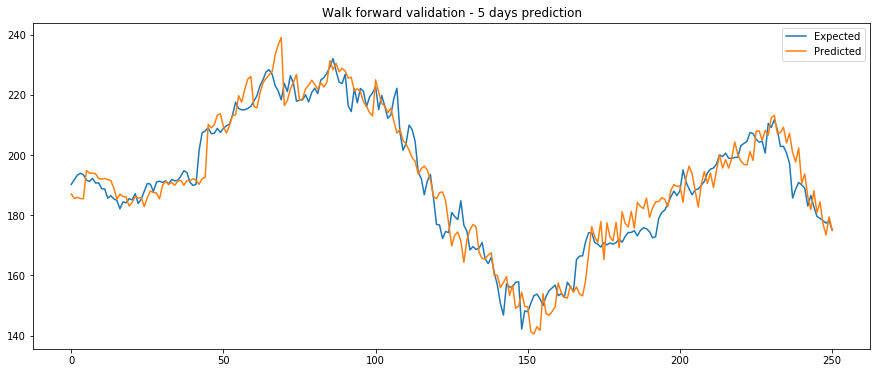

In [175]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(descaled_test[:size])
plt.plot(descaled_preds)
ax.set_title('Walk forward validation - 5 days prediction')
ax.legend(['Expected', 'Predicted'])

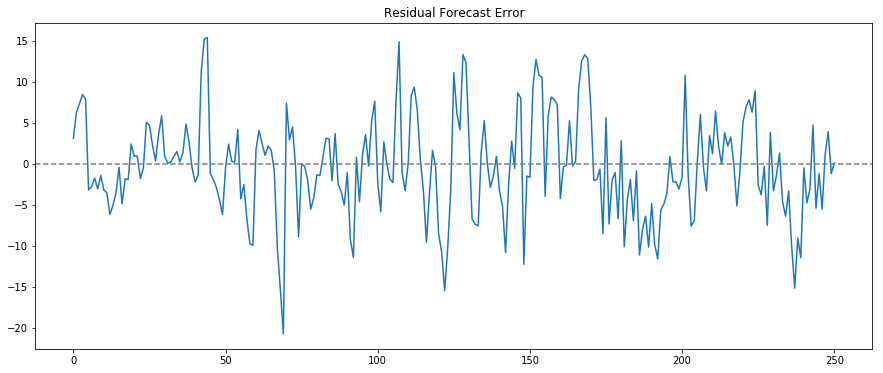

In [176]:
plot_residual_forecast_error(descaled_preds, descaled_test[:size])

In [177]:
print_performance_metrics(descaled_preds, 
                          descaled_test[:size],
                          model_name='MLP', 
                          total_days=size, steps=n_outputs)

MLP[252 days, 5 days forecast]:

Forecast Bias: -0.361
MAE: 4.656
MSE: 37.020
RMSE: 6.084
MAPE: 2.496


In [ ]:
model.load_weights('mlp-model_weights.h5')